In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error

In [4]:
# Clean up dataset  
time_df = pd.read_csv('nyc_data.csv')
time_df

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077
...,...,...,...,...,...,...,...
2187,12/27/2020,685.915026,0,0,0,2.89,38.674
2188,12/28/2020,998.051170,0,0,0,8.83,166.712
2189,12/29/2020,847.123399,0,0,0,3.48,161.865
2190,12/30/2020,857.521043,0,0,0,5.97,179.634


In [5]:
time_df = time_df[['Date', 'Demand']]
dates = pd.to_datetime(time_df['Date'])
df = pd.DataFrame()
df['year'] = dates.dt.year
df['month'] = dates.dt.month
df['day'] = dates.dt.day
df = df[df['day'] == 1]
df = df.reset_index()
df2 = time_df.groupby(pd.to_datetime(time_df['Date']).dt.to_period('M')).mean()
df2 = df2.reset_index()
df3 = df.join(df2)
time_df = pd.DataFrame({'year': df3['year'], 'month': df3['month'], 'day': df3['day']})
time_df = pd.to_datetime(time_df)
time_df = pd.DataFrame({'Month': time_df, 'Demand': df3['Demand']})
#time_df.drop(time_df.tail(12).index, inplace=True)
time_df = time_df.iloc[:-12]
time_df

,Month,Demand
0,2015-01-01,692.967611
1,2015-02-01,676.381042
2,2015-03-01,646.326069
3,2015-04-01,636.463333
4,2015-05-01,621.211624
5,2015-06-01,592.977187
6,2015-07-01,553.939339
7,2015-08-01,526.423455
8,2015-09-01,564.525124
9,2015-10-01,585.943189


<AxesSubplot:>

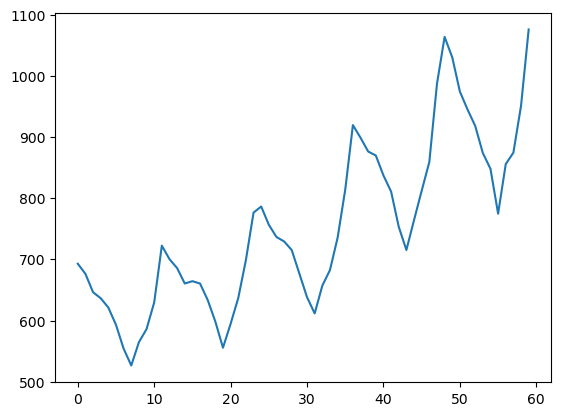

In [6]:
# Visualize the data
time_df['Demand'].plot()

In [7]:
# Testing for stationarity
test = adfuller(time_df['Demand'])
# H0: non stationary, H1: stationary
def adfuller_test(d):
    result = adfuller(d)
    labels = ['ADF Test Statistic', 'p-value', '#Lags used', 'No Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05: 
        print('Strong evidence against null, reject H0.')
    else: 
        print('Weak evidence against null, fail to reject H0. Time series has a unit root, indicating it is non-stationary')
adfuller_test(time_df['Demand'])

ADF Test Statistic : 2.6582380786870967
p-value : 0.9990836697896569
#Lags used : 11
No Observations Used : 48
Weak evidence against null, fail to reject H0. Time series has a unit root, indicating it is non-stationary


In [8]:
# Make data stationary, differencing 
time_df['Sales First Difference'] = time_df['Demand'] - time_df['Demand'].shift(1)
time_df['Seasonal First Difference'] = time_df['Demand'] - time_df['Demand'].shift(12)
time_df = time_df.set_index('Month')
time_df

,Demand,Sales First Difference,Seasonal First Difference
Month,,,
2015-01-01,692.967611,NaN,NaN
2015-02-01,676.381042,-16.586569,NaN
2015-03-01,646.326069,-30.054973,NaN
2015-04-01,636.463333,-9.862736,NaN
2015-05-01,621.211624,-15.251710,NaN
2015-06-01,592.977187,-28.234437,NaN
2015-07-01,553.939339,-39.037848,NaN
2015-08-01,526.423455,-27.515883,NaN
2015-09-01,564.525124,38.101668,NaN


In [9]:
# Dickey-Fuller Test
adfuller_test(time_df['Seasonal First Difference'].dropna())

ADF Test Statistic : -2.3666110443738577
p-value : 0.15138275175956029
#Lags used : 0
No Observations Used : 47
Weak evidence against null, fail to reject H0. Time series has a unit root, indicating it is non-stationary


<AxesSubplot:xlabel='Month'>

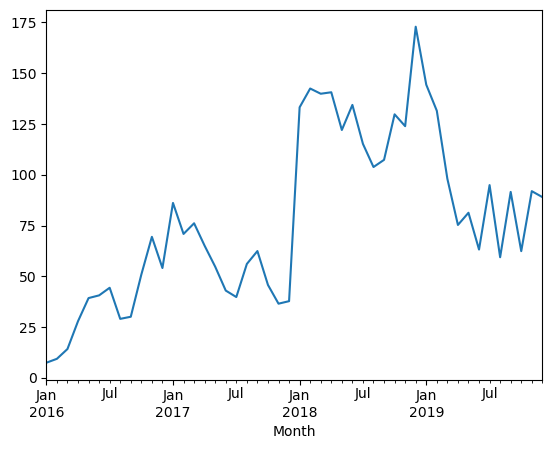

In [10]:
time_df['Seasonal First Difference'].dropna().plot()

/Users/sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


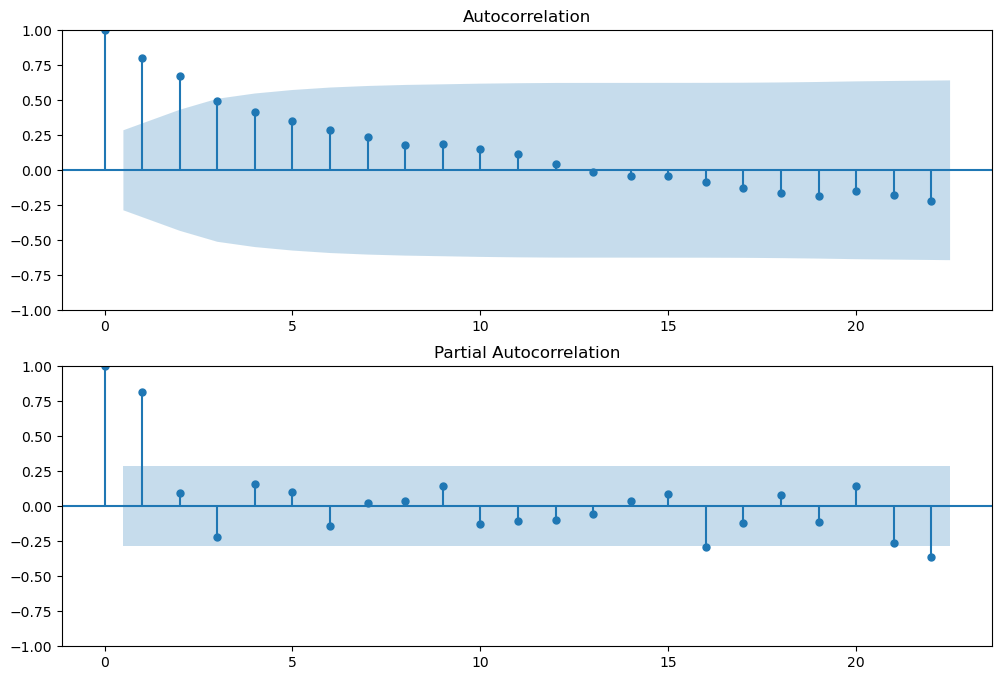

In [11]:
# Build auto regressive model
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = tsa.plot_acf(time_df['Seasonal First Difference'].iloc[13:], lags=22, ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsa.plot_pacf(time_df['Seasonal First Difference'].iloc[13:], lags=22, ax=ax2)

In [12]:
# p = 1 because that is the "shut-off" value (AR model)
# q = 1 because exponential decrease 
# d = 1 one seasonal differencing 

In [13]:
model = sm.tsa.statespace.SARIMAX(time_df['Demand'], order=(1,1,1), seasonal_order = (1,1,1,12))
results = model.fit()

/Users/sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sydney/opt/anaconda3/lib/python3.9/site-pack

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57890D+00    |proj g|=  1.21039D-01

At iterate    5    f=  3.55318D+00    |proj g|=  3.22026D-02

At iterate   10    f=  3.54144D+00    |proj g|=  1.63900D-03

At iterate   15    f=  3.54067D+00    |proj g|=  4.69340D-03

At iterate   20    f=  3.53993D+00    |proj g|=  1.47051D-03

At iterate   25    f=  3.53941D+00    |proj g|=  1.10582D-03

At iterate   30    f=  3.53929D+00    |proj g|=  2.21131D-03

At iterate   35    f=  3.53921D+00    |proj g|=  3.19932D-04

At iterate   40    f=  3.53920D+00    |proj g|=  1.23266D-04

At iterate   45    f=  3.53920D+00    |proj g|=  3.44365D-05

At iterate   50    f=  3.53919D+00    |proj g|=  3.54849D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Month'>

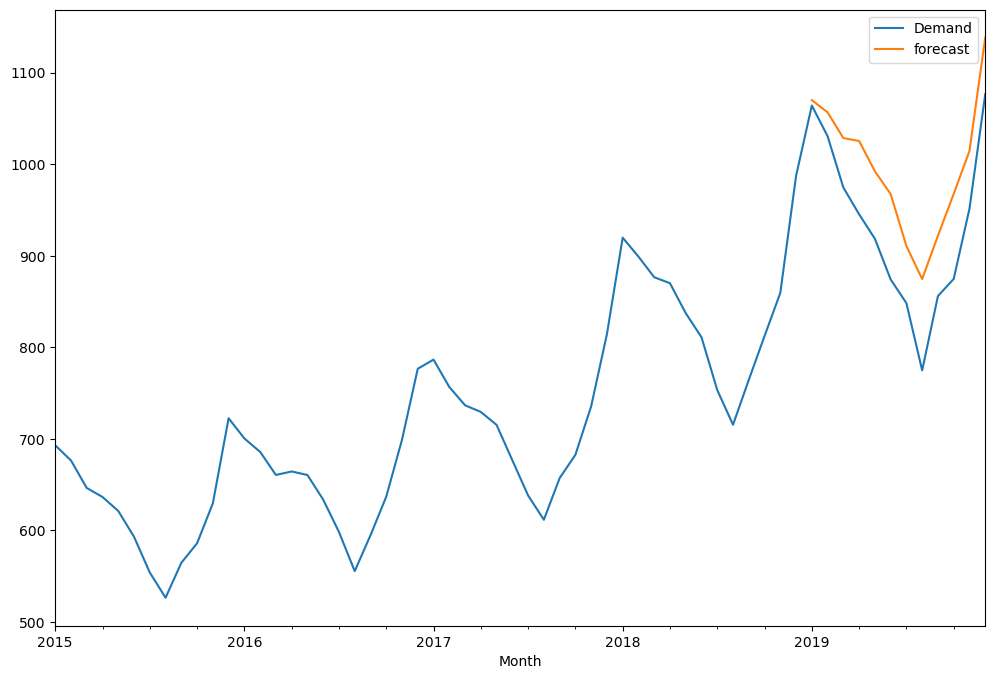

In [14]:
time_df['forecast'] = results.predict(start=48, end=59, dynamic=True)
time_df[['Demand', 'forecast']].plot(figsize = (12,8))

In [15]:
future_dates = [time_df.index[-1] + DateOffset(months=x) for x in range(0,60)]
df = pd.DataFrame(index=future_dates[1:], columns = time_df.columns)
df.tail()

,Demand,Sales First Difference,Seasonal First Difference,forecast
2024-07-01,NaN,NaN,NaN,NaN
2024-08-01,NaN,NaN,NaN,NaN
2024-09-01,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN
2024-11-01,NaN,NaN,NaN,NaN


In [16]:
df_vf = pd.concat([time_df, df])
df_vf

,Demand,Sales First Difference,Seasonal First Difference,forecast
2015-01-01,692.967611,NaN,NaN,NaN
2015-02-01,676.381042,-16.586569,NaN,NaN
2015-03-01,646.326069,-30.054973,NaN,NaN
2015-04-01,636.463333,-9.862736,NaN,NaN
2015-05-01,621.211624,-15.251710,NaN,NaN
...,...,...,...,...
2024-07-01,NaN,NaN,NaN,NaN
2024-08-01,NaN,NaN,NaN,NaN
2024-09-01,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN


<AxesSubplot:>

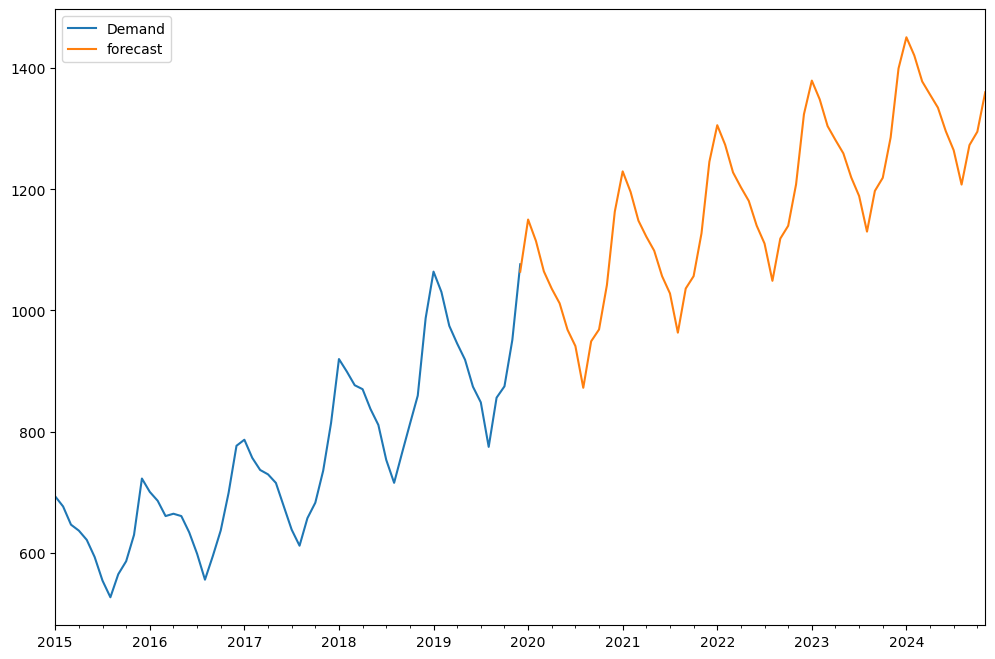

In [17]:
df_vf['forecast'] = results.predict(start = 59, end=120, dynamics=True)
df_vf[['Demand', 'forecast']].plot(figsize=(12,8))

In [18]:
df_vf

,Demand,Sales First Difference,Seasonal First Difference,forecast
2015-01-01,692.967611,NaN,NaN,NaN
2015-02-01,676.381042,-16.586569,NaN,NaN
2015-03-01,646.326069,-30.054973,NaN,NaN
2015-04-01,636.463333,-9.862736,NaN,NaN
2015-05-01,621.211624,-15.251710,NaN,NaN
...,...,...,...,...
2024-07-01,NaN,NaN,NaN,1264.521302
2024-08-01,NaN,NaN,NaN,1207.872187
2024-09-01,NaN,NaN,NaN,1273.043372
2024-10-01,NaN,NaN,NaN,1295.172879


# Holt Winters' Model

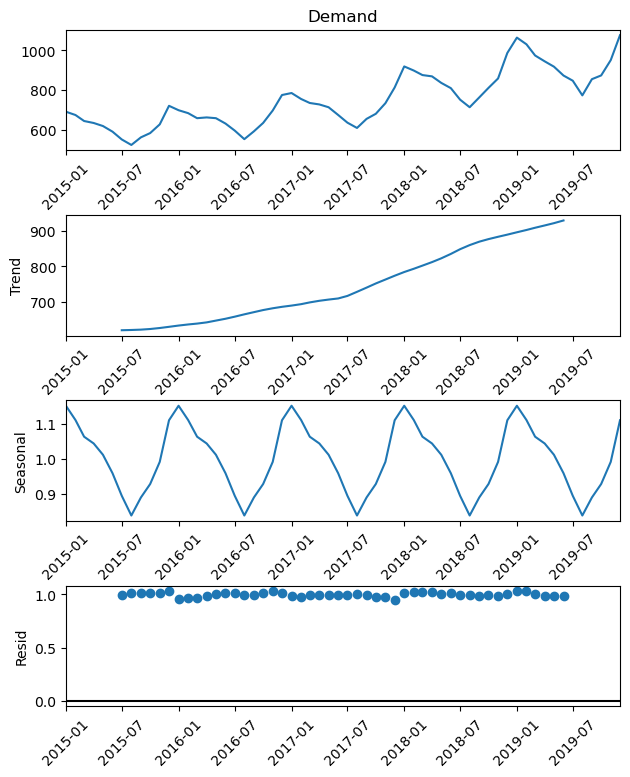

In [72]:
# Decompose data to get trend, seasonality, and noise

decomposed = seasonal_decompose(time_df['Demand'], model='multiplicative')
fig = decomposed.plot()

for ax in fig.get_axes():
    ax.tick_params(axis='x', rotation=45)

fig.set_figheight(8)
plt.show()

In [20]:

time_df.index.freq = 'MS'

train = time_df.iloc[:-12]
test = time_df.iloc[-12:]

In [21]:
hw_model = ExponentialSmoothing(train['Demand'], 
                                trend = 'mul', 
                                seasonal = 'mul', 
                                seasonal_periods = 12).fit(smoothing_level = 1/24)

hw_pred = hw_model.forecast(len(test))

/Users/sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


[]

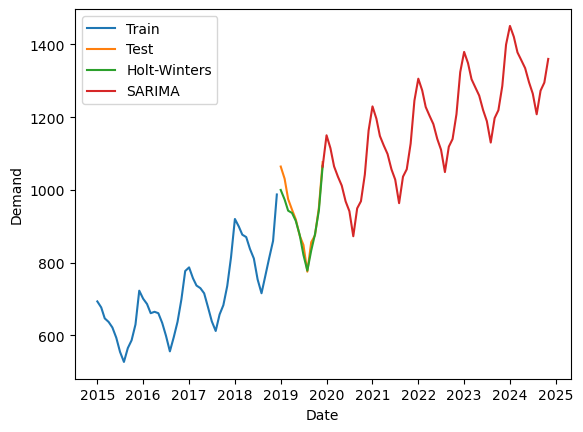

In [64]:
plt.plot(train['Demand'], label = 'Train')
plt.plot(test['Demand'], label = 'Test')
plt.plot(hw_pred, label = 'Holt-Winters')
plt.plot(df_vf['forecast'], label = 'SARIMA')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Demand')
plt.plot()

In [23]:
df_vf['forecast2'] = results.predict(start = test.index[0], end=test.index[-1], dynamics=True)


[]

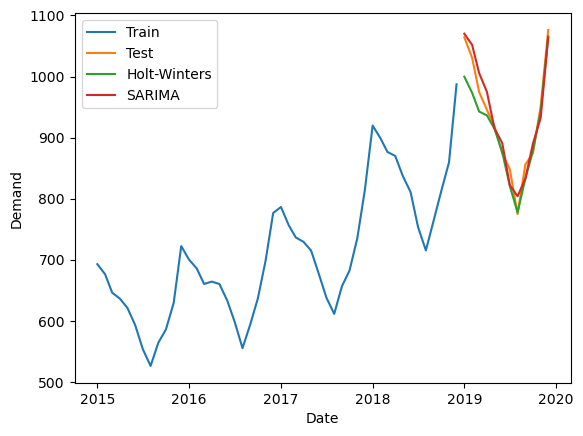

In [65]:
plt.plot(train['Demand'], label = 'Train')
plt.plot(test['Demand'], label = 'Test')
plt.plot(hw_pred, label = 'Holt-Winters')
plt.plot(df_vf['forecast2'], label = 'SARIMA')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Demand')
plt.plot()

In [67]:
# Comparing models

sarima_rmse = np.sqrt(mean_squared_error(test['Demand'], df_vf['forecast2'].loc[test.index]))
hw_rmse = np.sqrt(mean_squared_error(test['Demand'], hw_pred))
sarima_mean_error = abs(test['Demand'] - df_vf['forecast2'].loc[test.index]).mean()
sarima_max_error = abs(test['Demand'] - df_vf['forecast2'].loc[test.index]).max()
sarima_min_error = abs(test['Demand'] - df_vf['forecast2'].loc[test.index]).min()
hw_mean_error = abs(test['Demand'] - hw_pred).mean()
hw_max_error = abs(test['Demand'] - hw_pred).max()
hw_min_error = abs(test['Demand'] - hw_pred).min()

In [68]:
# Final results

sarima = [sarima_rmse, sarima_mean_error, sarima_max_error, sarima_min_error]
hw = [hw_rmse, hw_mean_error, hw_max_error, hw_min_error]

res = pd.DataFrame(data = {'SARIMA': sarima, 'Holt-Winters': hw},
                   index = ['RMSE', 'Mean Error', 'Max Error', 'Min Error'])

res

,SARIMA,Holt-Winters
RMSE,21.225034,28.892154
Mean Error,19.375007,20.285316
Max Error,30.983765,64.435805
Min Error,3.477880,2.018773
